In [52]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import catboost
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
import plotly.express as px
import streamlit as st
pd.set_option('display.max_columns', None)
plt.rcParams["figure.figsize"] = (20,4)
%matplotlib inline

In [5]:
regression = pd.read_excel('../../data/Shortage_regression.xlsx',dtype={'PHASE':str})
claims = pd.read_excel('../../data/Shortage_Graphs.xlsx',dtype={'PHASE':str})

In [45]:
print(regression.shape)
regression.head(1)

(31474, 28)


,UID,SHORTAGE,ORIGINAL_JOB_NUM,ORIGINAL_MFG_PLANT,PHASE,REASON,CUSTOMER_NAME,COMPANY,BRAND,Major Category,COMPLEXITY,OPL,Minor Category,RELEASE_DATE,GL_PERIOD,SQUAD,TEAM,BSR,SHORTAGE_COST_SPREAD,RELEASE_DATE_MONTH,GL_PERIOD_MONTH,RELEASE_DATE_YEAR,GL_PERIOD_YEAR,logy_target,PIECEMARK,SALES_REGION_ID,SALES_DISTRICT_ID,DEPARTMENT_RESPONSIBLE
0,18S559050101CECOElizabethton17B89685,18S55905,17B89685,Elizabethton,0101,0415 - Error due to Engineering Scheduling,BORRELLI METAL BUILDINGS,CECO BUILDING SYSTEMS,CECO,Comm Ops,8,PENNAR,Eng. Scheduling,2022-02-22 00:00:00,2022-08-23,PENNAR,PENNAR,CARRIE SCHAFER,760.0,2,8,2022,2022,6.63345,1 LOT-0100,C100,C103,415


In [44]:
print(claims.shape)
claims.head(1)

(15929, 47)


,UID,SHORTAGE,ORIGINAL_JOB_NUM,PHASE,BRAND,ORIGINAL_MFG_PLANT,CUSTOMER,CUSTOMER_NAME,COMPANY,REASON,SQUAD,SQUAD2,TEAM,TEAM2,TEAM3,CHECKER,CHECKER2,DETAILER,DETAILER2,Major Category,Major Category2,Minor Category,Minor Category2,NOTES,OPL,Selling Brand,BSR,INVESTIGATION_RESULT,HOW_ERROR_OCCURRED,PREVENTATIVE_ACTIONS,RESPONSE_BY,RELEASE_DATE,ORIGINAL_JOB_SHIP,GL_PERIOD,SHORTAGE_COST_SPREAD,SHORTAGE_PERIOD_COST,FREIGHT,MATERIAL,OVERHEAD,LABOR,ORIGINAL_JOB_AMOUNT,AUTHORIZED_BY,COMPLEXITY,RELEASE_DATE_MONTH,GL_PERIOD_MONTH,RELEASE_DATE_YEAR,GL_PERIOD_YEAR
0,18S500110101STARElizabethton18B25260,18S50011,18B25260,0101,STAR,Elizabethton,R YODER CONSTRUCTION INC :254906,R YODER CONSTRUCTION INC,STAR BUILDING SYSTEMS,2702 - Incorrect Order Write Up - Non Standard...,SRG,NaN,SRG,NaN,NaN,SCOTT KITCHEN,NaN,SCOTT KITCHEN,NaN,Comm Ops,NaN,Order Clarity Issues,NaN,BUILDER REPORTED THAT FRAMES WERE NOT DESIGN F...,NA Contractor,STAR,WARREN NORMAN,NaN,NaN,NaN,NaN,2021-11-10,2021-12-11,2022-05-23,93990.68,93990.68,0.0,60663.36,20202.54,13124.78,1952790.63,TERRY STANDIFER,8.0,11.0,5.0,2021.0,2022.0


In [9]:
eda_slice = claims.copy()

In [60]:
def run_iteration(eda_slice, reg_slice, filter_dim, filter_val, group_level):
    
    if filter_dim or filter_val:
        eda_slice = eda_slice[eda_slice[filter_dim] == filter_val] # EDA slice 1

    cat_spread = eda_slice.drop_duplicates([group_level,'SHORTAGE','SHORTAGE_COST_SPREAD']) 
    cat_spread =  cat_spread.groupby(group_level)['SHORTAGE_COST_SPREAD'].sum().sort_values(ascending=False).reset_index() # group by
    cat_spread['Cost Spread %'] = cat_spread['SHORTAGE_COST_SPREAD']/cat_spread['SHORTAGE_COST_SPREAD'].sum()*100
    cat_spread = cat_spread[cat_spread[group_level]!='missing']
    cat_spread[group_level] = cat_spread[group_level].astype(str)
    cat_spread['Cost Spread %'] = cat_spread['Cost Spread %'].round()
    cat_spread = cat_spread.iloc[:5]
    fig1 = px.bar(cat_spread,group_level,'Cost Spread %',color='Cost Spread %')

    options = ['Unselected'] + cat_spread[group_level].unique().tolist()
    value = st.radio( "Choose Value", options) 

    if value != 'Unselected':
        # Reg 2

        # st.markdown(f"### Regression analysis for {value}")

        target = 'logy_target'
        columns1 = ['COMPANY','PHASE','BRAND','Major Category','COMPLEXITY','OPL','ORIGINAL_MFG_PLANT', target]
        columns2 = ['Minor Category','GL_PERIOD_MONTH','RELEASE_DATE_MONTH', 'SALES_REGION_ID','SQUAD','TEAM','REASON','BSR'] #,'CHECKER','DETAILER'
        columns3 = ['SALES_DISTRICT_ID', 'PIECEMARK','CUSTOMER_NAME']
        columns = columns1 + columns2


        reg_slice =  reg_slice[(reg_slice[group_level]==value)] # Reg Slice 2
        X = reg_slice[columns]
        X = X.dropna(subset=[target])
        X = X.drop_duplicates()
        X =pd.get_dummies(X)
        y = X[target]
        X = X.drop(target, axis=1)

        # Split the dataset into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


        model = RandomForestRegressor(max_depth=None,)
        model.fit(X_train, y_train)

        feature_importances = model.feature_importances_
        importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
        importance_df['Column'] = importance_df['Feature'].str.split("_").apply(lambda x: '_'.join(x[:-1]) if len(x)>1 else x[0] )
        importance_df['Value'] = importance_df['Feature'].str.split("_").apply(lambda x: x[-1] if len(x) > 1 else 'none')
        feature_importance_df = importance_df.groupby('Column')['Importance'].sum().sort_values(ascending=False).reset_index()
        feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
        feature_importance_df['Importance'] = feature_importance_df['Importance'].apply(lambda x: "{:f}".format(x))
        feature_importance_df['Importance'] = feature_importance_df['Importance'].apply(lambda x: float(x))
        top_features = feature_importance_df.head(5)


        fig2 = px.bar(top_features,'Importance','Column',orientation='h')
        # st.write(fig1)

        filter_dim = group_level
        filter_val = value
        group_level = st.radio( "Choose Dimension",  ['Unselected'] + top_features['Column'].unique().tolist()) 
        print(group_level)
        level+=1
        print('Level update to ',level)
        
    return (fig1,fig2)

In [61]:
graph1,graph2 = run_iteration(eda_slice,regression,None,None,'Major Category')

UnboundLocalError: cannot access local variable 'fig2' where it is not associated with a value

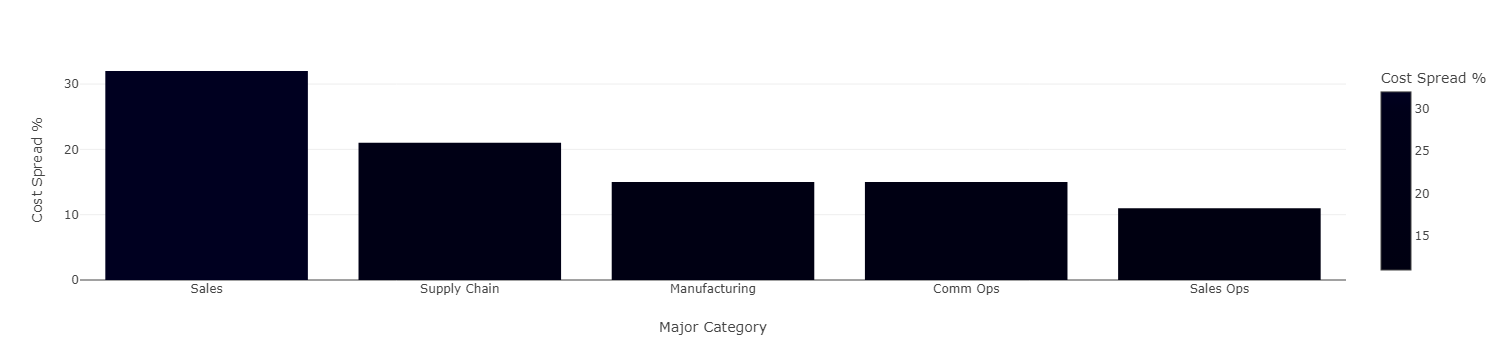

In [58]:
graph1